In [8]:
import pandas as pd
import seaborn as sb
import joblib
import matplotlib.pyplot as plt
import truvari

In [2]:
# 1- I need to make the counts for >=5bp from rtg for the table
rtg = joblib.load("data/rtg.jl")

In [5]:
view = rtg[rtg['svlen'] >= 5]
counts = view['state'].value_counts()
counts

tp         124902
tp-base    118173
fp          28437
fn          18612
Name: state, dtype: int64

In [10]:
prec, recall, f1 = truvari.performance_metrics(counts['tp-base'], counts['tp'], counts['fn'], counts['fp'])
print(prec, recall, f1)

0.8145481580028564 0.8639324487334138 0.8385138105623284


In [6]:
counts['tp'] + counts['fp']

153339

In [7]:
refine = joblib.load("data/ga4gh_query.jl")
len(refine)

151120

In [35]:
view['state'].value_counts()

tp         124902
tp-base    118173
fp          28437
fn          18612
Name: state, dtype: int64

In [40]:
parts = []
for sz, dat in view.groupby('szbin'):
    if sz in ["SNP", "[1,5)", "[1k,2.5k)", "[2.5k,5k)", ">=5k"]:
        continue
    m = dat['state'].value_counts()
    m['precision'], m['recall'], m['f1'] = truvari.performance_metrics(m['tp-base'], m['tp'], m['fn'], m['fp'])
    m['size'] = sz
    parts.append(m)
rtg_summary = pd.concat(parts, axis=1).T.reset_index(drop=True)
rtg_summary['program'] = 'vcfeval'

In [43]:
truv = joblib.load("data/bench_all.jl")
parts = []
for sz, dat in truv.groupby('szbin'):
    if sz in ["SNP", "[1,5)"]:
        continue
    m = dat['state'].value_counts()
    m['precision'], m['recall'], m['f1'] = truvari.performance_metrics(m['tpbase'], m['tp'], m['fn'], m['fp'])
    m['size'] = sz
    parts.append(m)
tru_bench_summary = pd.concat(parts, axis=1).T.reset_index(drop=True)
tru_bench_summary['program'] = 'bench'


In [83]:
#truv = joblib.load("data/bench_all.jl")
#truv = joblib.load("data/bench_gt50.jl")
truv = joblib.load("data/bench_multi.jl")
parts = []
for sz, dat in truv.groupby('szbin'):
    if sz in ["SNP", "[1,5)"]:
        continue
    m = dat['state'].value_counts()
    m['precision'], m['recall'], m['f1'] = truvari.performance_metrics(m['tpbase'], m['tp'], m['fn'], m['fp'])
    m['size'] = sz
    parts.append(m)
tru_bench_summary = pd.concat(parts, axis=1).T.reset_index(drop=True)
tru_bench_summary['program'] = 'bench'


In [87]:
d1 = joblib.load("data/ga4gh_query.jl").rename(columns={"syndip_BD":"state"})
d1['state'] = d1['state'].map({'TP':"tpbase", 'FP':'fp'})
d2 = joblib.load("data/ga4gh_truth.jl").rename(columns={"HG002_BD":"state"})
d2['state'] = d2['state'].map({'TP':"tp", 'FN':'fn'})
d = pd.concat([d1, d2])
parts = []
for sz, dat in d.groupby('szbin'):
    if sz in ["SNP", "[1,5)"]:
        continue
    m = dat['state'].value_counts()
    m['precision'], m['recall'], m['f1'] = truvari.performance_metrics(m['tpbase'], m['tp'], m['fn'], m['fp'])
    m['size'] = sz
    parts.append(m)
tru_refine_summary = pd.concat(parts, axis=1).T.reset_index(drop=True)
tru_refine_summary['program'] = 'refine'

In [88]:
all_summary = pd.concat([rtg_summary, tru_bench_summary, tru_refine_summary])

In [89]:
view = all_summary.melt(id_vars=['program', 'size'], value_vars=['precision', 'recall', 'f1'])

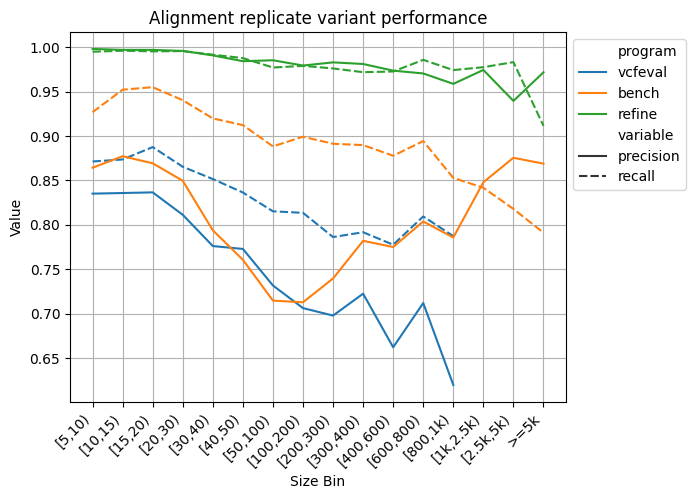

In [90]:
p = sb.lineplot(data=view[view['variable'] != 'f1'], x="size", y="value", hue="program", style="variable")
sb.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
p.set(title="Alignment replicate variant performance", xlabel="Size Bin", ylabel="Value")
plt.grid()  #just add this
p.set_axisbelow(True)
plt.savefig("Figure3B.pdf")

<Axes: xlabel='size', ylabel='precision'>

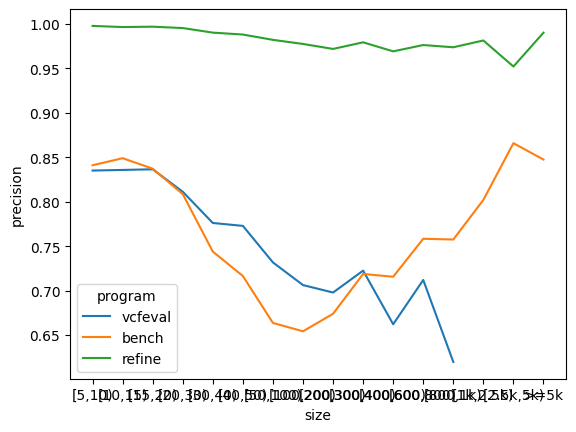

In [60]:
sb.lineplot(data=all_summary, x="size", y="precision", hue="program")

<Axes: xlabel='size', ylabel='recall'>

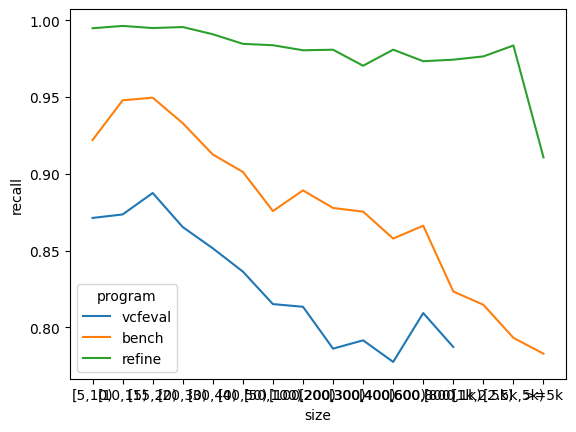

In [61]:
sb.lineplot(data=all_summary, x="size", y="recall", hue="program")

<Axes: xlabel='size', ylabel='f1'>

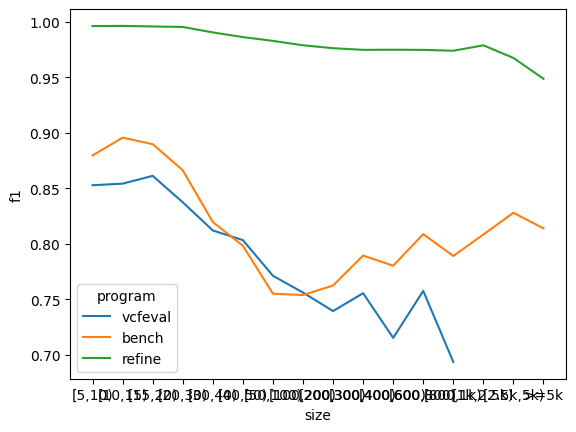

In [62]:
sb.lineplot(data=all_summary, x="size", y="f1", hue="program")